In [125]:
import pandas as pd
import unicodedata
import string
import re
import numpy as np
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from statistics import mean
plt.style.use('ggplot')
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


## EDA!

In [2]:
df = pd.read_csv('data/speech_df_cleaned.csv')

In [3]:
df.head()

,Unnamed: 0,index,name,party,war,speech,title,date,text,interview,debate,inaugural address,state of the union,press conference
0,0,0,bush,republican,war,"<title=""Address at West Point"">\n<date=""Januar...",Address at West Point,"January 5, 1993",\nThank you all very much. Good luck. Please b...,False,False,False,False,False
1,1,1,bush,republican,war,"<title=""Address on Somalia"">\n<date=""December ...",Address on Somalia,"December 4, 1992",\nI want to talk to you today about the traged...,False,False,False,False,False
2,2,2,bush,republican,war,"<title=""Address on Iraq's Invasion of Kuwait"">...",Address on Iraq's Invasion of Kuwait,"August 8, 1990","\nIn the life of a nation, we're called upon t...",False,False,False,False,False
3,3,3,bush,republican,war,"<title=""Address Before a Joint Session of Cong...",Address Before a Joint Session of Congress,"September 11, 1990",\nMr. President and Mr. Speaker and Members of...,False,False,False,False,False
4,4,4,bush,republican,war,"<title=""Remarks at Texas A and M University"">\...",Remarks at Texas A and M University,"December 15, 1992",\nThank you all for that welcome back. Thank y...,False,False,False,False,False


In [4]:
df.count()

Unnamed: 0            549
index                 549
name                  549
party                 549
war                   549
speech                549
title                 549
date                  549
text                  548
interview             549
debate                549
inaugural address     549
state of the union    549
press conference      549
dtype: int64

The 549 texts included 16 Democrats (7 presidents, 9 debate candidates) and 15 Republicans (7 presidents, 8 debate candidates).

In [5]:
print('Speeches by president')
print(df.name.value_counts())
print('')
print('speeches by party')
print(df.party.value_counts())

Speeches by president
lbjohnson      71
reagan         60
obama          54
fdroosevelt    49
kennedy        45
gwbush         45
clinton        43
hoover         29
bush           27
nixon          27
carter         22
truman         19
ford           17
eisenhower      6
gore            5
mccain          3
kerry           3
romney          3
quayle          2
cheney          2
biden           2
dole            2
dukakis         2
mondale         2
palin           1
edwards         1
ryan            1
bentsen         1
lieberman       1
ferraro         1
kemp            1
kaine           1
pence           1
Name: name, dtype: int64

speeches by party
democrat      322
republican    227
Name: party, dtype: int64


Speeches by speaker

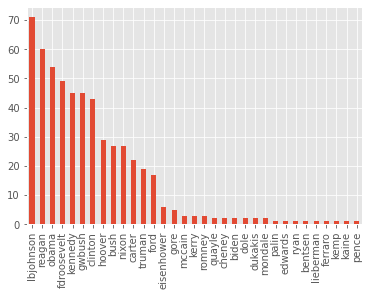

In [6]:
df['name'].value_counts().plot(kind='bar')

LBJ had the most speeches, which lead me to wonder if these were disproportionately press conferences due to the Vietnam War.  It turns out that yes, he had the most press conferences in the corpus, 23 in total.

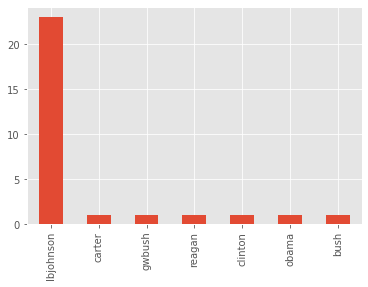

In [7]:
df[df['press conference']== True]['name'].value_counts().plot(kind='bar')

The table below shows the breakdown of speech type by speaker.

In [8]:
df.groupby('name').sum()

,Unnamed: 0,index,interview,debate,inaugural address,state of the union,press conference
name,,,,,,,
bentsen,545,46,0.0,1.0,0.0,0.0,0.0
biden,1016,18,0.0,2.0,0.0,0.0,0.0
bush,2425,429,0.0,6.0,1.0,3.0,1.0
carter,737,737,0.0,4.0,1.0,3.0,1.0
cheney,1049,51,0.0,2.0,0.0,0.0,0.0
clinton,4597,2614,0.0,5.0,0.0,7.0,1.0
dole,1028,43,0.0,2.0,0.0,0.0,0.0
dukakis,1031,46,0.0,2.0,0.0,0.0,0.0
edwards,522,23,0.0,1.0,0.0,0.0,0.0


In [21]:
df.text = df.text.fillna(' ')

In [22]:
df['text length'] = df.text.apply(lambda x: len(x.split(' ')))

The median speech length was 3,176 words, which assuming 150 words/minute means 21.17 minutes.

In [23]:
df['text length'].median()/150

21.173333333333332

In [24]:
df[df['party'] == 'democrat']['text length'].sum()

1118720

In [25]:
df[df['party'] == 'republican']['text length'].sum()

790496

In [26]:
df.sort_values(by='text length', ascending=True)

,Unnamed: 0,index,name,party,war,speech,title,date,text,interview,debate,inaugural address,state of the union,press conference,text length
544,544,45,dukakis,democrat,0,0,0,0,,False,True,False,False,False,2
120,120,120,fdroosevelt,democrat,war,"<title=""Message to Congress Requesting War Dec...",Message to Congress Requesting War Declaration...,"December 11, 1941","<title=""Message to Congress Requesting War Dec...",False,False,False,False,False,144
202,202,202,hoover,republican,nw,"<title=""Message Regarding “Black Thursday”"">\n...",Message Regarding “Black Thursday”,"October 25, 1929",\n<IN REPLY to press questions as to the busin...,False,False,False,False,False,204
307,307,307,lbjohnson,democrat,war,"<title=""Statement on Sending Troops to the Dom...",Statement on Sending Troops to the Dominican R...,"April 28, 1965",\nI have just concluded a meeting with the lea...,False,False,False,False,False,241
355,355,355,nixon,republican,war,"<title=""Remarks Announcing an Agreement on Str...",Remarks Announcing an Agreement on Strategic A...,"May 20, 1971","\nGood afternoon, ladies and gentlemen:\nAs yo...",False,False,False,False,False,264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,214,214,hoover,republican,nw,"<title=""First State of the Union Address"">\n<d...",First State of the Union Address,"December 3, 1929",\nTo the Senate and House of Representatives:\...,False,False,False,True,False,10830
8,8,8,bush,republican,war,"<title=""Press Conference with Mikhail Gorbache...",Press Conference with Mikhail Gorbachev,"July 31, 1991","\n\n<President Gorbachev. Good evening, ladies...",False,False,False,False,True,11902
509,509,10,mccain,republican,0,0,0,0,"well, thank you, jim. and thanks to everybody...",False,True,False,False,False,12353
510,510,11,obama,democrat,0,0,0,0,"well, thank you very much, jim, and thanks to...",False,True,False,False,False,13229


The shortest text was FDR's declaration of war on Germany and Italy.

In [27]:
df.iloc[120].text

'<title="Message to Congress Requesting War Declarations with Germany and Italy">\n<date="December 11, 1941">\nTo the Congress:\nOn the morning of December eleventh, the Government of Germany, pursuing its course of world conquest, declared war against the United States.\nThe long known and the long expected has thus taken place. The forces endeavoring to enslave the entire world now are moving toward this hemisphere.\nNever before has there been a greater challenge to life, liberty, and civilization.\nDelay invites greater danger. Rapid and united effort by all of the peoples of the world who are determined to remain free will insure a world victory of the forces of justice and of righteousness over the forces of savagery and of barbarism.\nItaly also has declared war against the United States.\nI therefore request the Congress to recognize a state of war between the United States and Germany, and between the United States and Italy.\n'

In [28]:
vocab = set()
total = []
df['text'].str.lower().str.split().apply(vocab.update)
df['text'].str.lower().str.split().apply(total.append)
total = [item for sublist in total for item in sublist]
print(f'The vocabulary of the corpus is {len(vocab)} unique words & {len(total)} total words.')

The vocabulary of the corpus is 57629 unique words & 1928737 total words.


The distribution of the word counts by party is roughly the same.

Text(0.5, 1.0, 'Word Count by Party')

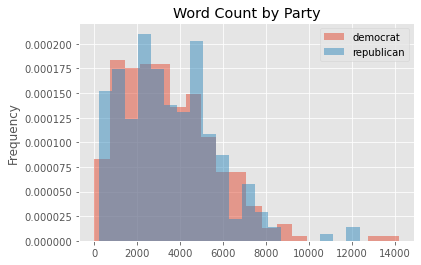

In [29]:
fig, ax = plt.subplots()
df[df['party'] == 'democrat']['text length'].plot(kind = 'hist', bins = 20, density = 'true', alpha = .5, label = 'democrat')
df[df['party'] == 'republican']['text length'].plot(kind = 'hist', bins = 20, density = 'true', alpha = .5, label = 'republican')
ax.legend()
ax.set_title('Word Count by Party')

# Testing

This section includes:
1. The initial Multinomial Bayes Model and the hyperparameters optimizaitons.
1. The Multinomial Naive Bayes Model used to predict whether a text is from a Democrat or a Republican
1. The top tri-grams unique to each party (by log probability)
1. The optimized Random Forest Classifier that ultimately was not used

In [34]:
## returns the top features for dems republications (by log probability), as well as the features that are unique to 
#each party in the top num_features
def get_top_features(feature_logs, labels, num_features):
    zero_all = np.array(labels)[np.argsort(feature_logs[0])[-1*num_features:]]
    one_all = np.array(labels)[np.argsort(feature_logs[1])[-1*num_features:]]
    zero_unique = [x for x in zero_all if x not in one_all]
    one_unique = [x for x in one_all if x not in zero_all]
    return zero_all, one_all, zero_unique, one_unique


### Initial Model:

In [110]:
## Initial model has 25% recall for republicans and a cross validation score of .66
## Multinomial Naive Bayes Model
def run_model_initial(X, y, max_feat = 200, stop_words = stopwords.words('english')):
    tfidf = TfidfVectorizer(stop_words = sw, ngram_range = (1,3), max_features = max_feat)
    X = tfidf.fit_transform(X)
    labels = tfidf.get_feature_names()
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 5)
# %
    clf = MultinomialNB()
    clf = clf.fit(X_train, y_train)
    cvs = np.mean(cross_val_score(clf, X_train, y_train))
    return clf, cvs, X_test, y_test, labels, X, tfidf
    
clf, cvs, X_test, y_test, labels, X, tfidf = run_model_initial(df.text, df.party, stop_words = sw)

td, fr, fd, tr = confusion_matrix(y_test, clf.predict(X_test)).ravel()
print(f'True Dems: {td}, False Republicans: {fr}, False Dems: {fd}, True Republicans: {tr}')
print(f'Recall for Democrats: {td/(td + fr)}')
print(f'Recall for Republicans: {tr/(fd + tr)}')
print(f'Cross-validation score: {cvs}')

zero, one, zero_unique, one_unique = get_top_features(clf.feature_log_prob_, labels, 50)

print(" ")
print(f'Dem unique: {zero_unique}')
print(f'Rep unique: {one_unique}')

True Dems: 79, False Republicans: 2, False Dems: 43, True Republicans: 14
Recall for Democrats: 0.9753086419753086
Recall for Republicans: 0.24561403508771928
Cross-validation score: 0.6594475462826918
 
Dem unique: ['vietnam', 'back', 'take', 'south', 'still', 'power', 'much', 'even', 'go', 'hope', 'children']
Rep unique: ['state', 'together', 'system', 'nuclear', 'thank', 'union', 'senator', 'economic', 'iraq', 'federal', 'soviet']


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.784


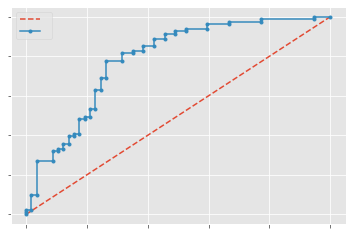

In [111]:
clf, cvs, X_test, y_test, _, _, _ = run_model_initial(df.text, df.party, max_feat = 200, stop_words = stopwords.words('english'))
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


# generate a no skill prediction (majority class)
y_test_coded = []
for i in y_test:
    if i == 'democrat':
        y_test_coded.append(1)
    else:
        y_test_coded.append(0)
    
    
ns_probs = [0 for _ in range(len(y_test))]
mnb_probs = clf.predict_proba(X_test)
# keep probabilities for being a republican only (column 1), democrat (column 0)
mnb_probs = mnb_probs[:, 0]
# calculate scores
ns_auc = roc_auc_score(y_test_coded, ns_probs)
mnb_auc = roc_auc_score(y_test_coded, mnb_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (mnb_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test_coded, ns_probs)
mnb_fpr, mnb_tpr, _ = roc_curve(y_test_coded, mnb_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(mnb_fpr, mnb_tpr, marker='.', label='Multinomial Bayes')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Credit for the ROC code goes to https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

### Exploring Recall & Accuracy as a function of the number of features
I looked at the tradeoff between accuracy and recall for each party, ultimately deciding to work within a range of 1000 to 1500 features

In [37]:
feat = np.arange(500, 10000, 250)
acc = []
recall_dems = []
recall_rep = []
for i in feat:
    clf, cvs, X_test, y_test, _, _, _ = run_model_initial(df.text, df.party, max_feat = i, stop_words = sw)
    td, fr, fd, tr = confusion_matrix(y_test, clf.predict(X_test)).ravel()
    recall_d = td/(td + fr)
    recall_r = tr/(fd + tr)
    acc.append(cvs)
    recall_dems.append(recall_d)
    recall_rep.append(recall_r)


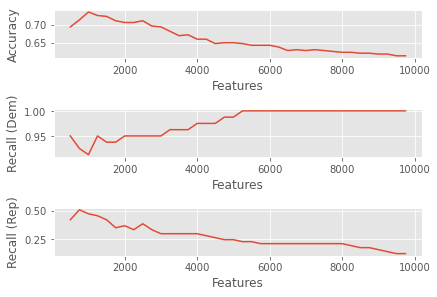

In [38]:
fig, ax = plt.subplots(3,1)

ax[0].plot(feat, acc)
ax[0].set_xlabel('Features')
ax[0].set_ylabel('Accuracy')
ax[1].plot(feat, recall_dems)
ax[1].set_xlabel('Features')
ax[1].set_ylabel('Recall (Dem)')
#ax[0].scatter([feat[np.argsort(acc)[-5:]]], acc[np.argsort(acc)[-5:]])
#ax[0].title('Features vs Accuracy')
ax[2].plot(feat, recall_rep)
ax[2].set_xlabel('Features')
ax[2].set_ylabel('Recall (Rep)')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

As the features grew, the model began to classify more people as Democrats.

### ROC Curve with 1500 features & updated stopwords

In [33]:
sw = stopwords.words('english')

new_sw = ['also', '000', 'see', 'come', 'day','say', 'us', 'well', 'le', "'m", 'made', 'applause', 'mr', 'men', 'candidate', 'instead', 'q', 'part', "'re", "'le", 'get', 'man', "'ve", 'let', 'every', 'may', 'upon', 'shall', 'going','ve','year', '--', '``', "'s", "''", 'way', 'cannot', 'two', 'long', 'said', 'like', 'years', 'think','would',"n't", 'must','u','many','one','first','last',"'re'", 'today','', 'ha', 'wa']
for i in new_sw:
    sw.append(i)



In [39]:
clf, cvs, X_test, y_test, _, _, _ = run_model_initial(df.text, df.party, max_feat = 1500, stop_words = sw)

In [40]:
td, fr, fd, tr = confusion_matrix(y_test, clf.predict(X_test)).ravel()
print(f'True Dems: {td}, False Republicans: {fr}, False Dems: {fd}, True Republicans: {tr}')
print(f'Recall for Democrats: {td/(td + fr)}')
print(f'Recall for Republicans: {tr/(fd + tr)}')

True Dems: 76, False Republicans: 5, False Dems: 33, True Republicans: 24
Recall for Democrats: 0.9382716049382716
Recall for Republicans: 0.42105263157894735


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.870


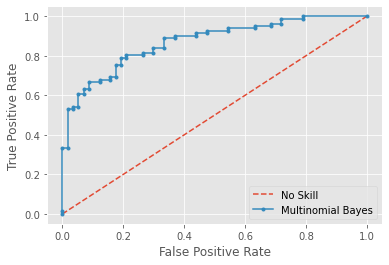

In [41]:
# generate a no skill prediction (majority class)
y_test_coded = []
for i in y_test:
    if i == 'democrat':
        y_test_coded.append(1)
    else:
        y_test_coded.append(0)
    
    
ns_probs = [0 for _ in range(len(y_test))]
mnb_probs = clf.predict_proba(X_test)
# keep probabilities for being a republican only (column 1), democrat (column 0)
mnb_probs = mnb_probs[:, 0]
# calculate scores
ns_auc = roc_auc_score(y_test_coded, ns_probs)
mnb_auc = roc_auc_score(y_test_coded, mnb_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (mnb_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test_coded, ns_probs)
mnb_fpr, mnb_tpr, _ = roc_curve(y_test_coded, mnb_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(mnb_fpr, mnb_tpr, marker='.', label='Multinomial Bayes')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

### Picking a threshold
The area under the curve (AUC) score increased to .870 so next next I graphed accuracy as a function of different thresholds to pick a threshold for this model.

Note: In my January 2021 update, I do a grid search to scored based on AUC to find hyperparameters, which would have been a more comprehensive approach than looking at the graphs of features vs accuracy and recall.  I chose to optimize for AUC because I wanted to both maximize TPR and minimize FPR in order to raise the recall for Republicans.  This code is later in the notebook.

In [42]:
y_test_array = y_test.to_numpy()

Text(0, 0.5, 'Accuracy')

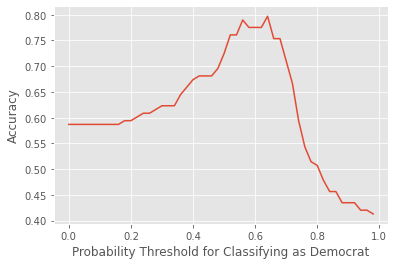

In [43]:
from statistics import mean
dem_prob = clf.predict_proba(X_test)[:,0]
thresh = np.arange(0,1, .02)
y_test
thresh_acc =[]

for t in thresh:
    correct = []
    for i,v in enumerate(dem_prob):
        if v >= t and y_test_array[i] =='democrat':
            correct.append(1)
        elif v<t and y_test_array[i] == 'republican':
            correct.append(1)
        else:
            correct.append(0)
    thresh_acc.append(mean(correct))

fig, ax = plt.subplots()
ax.plot(thresh, thresh_acc)
ax.set_xlabel('Probability Threshold for Classifying as Democrat')
ax.set_ylabel('Accuracy')
    

It appears that the optimal threshold is between .56 and .64; however, once I changed from 1-3grams to just trigrams in my model, I found that the best threshold was .54.

## The main model
This is my main model with 1500 features, trigrams only, special stopwords, and a .54 threshold for classification as Democrat.

In [132]:
## Multinomial Naive Bayes Model
def run_model(X, y, max_feat = 1500, stop_words = sw):
    tfidf = TfidfVectorizer(stop_words = sw, ngram_range = (3,3), max_features = max_feat)
    X = tfidf.fit_transform(X)
    labels = tfidf.get_feature_names()
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 5)
# %
    clf = MultinomialNB()
    clf = clf.fit(X_train, y_train)
    cvs = np.mean(cross_val_score(clf, X_train, y_train))
    return clf, cvs, X_test, y_test, labels, X, tfidf
    
clf, cvs, X_test, y_test, labels, X, tfidf = run_model(df.text, df.party, stop_words = sw)

The confusion matrix is broken down below:

In [128]:
td, fr, fd, tr = confusion_matrix(y_test, clf.predict(X_test)).ravel()
print(f'True Dems: {td}, False Republicans: {fr}, False Dems: {fd}, True Republicans: {tr}')
print(f'Recall for Democrats: {td/(td + fr)}')
print(f'Recall for Republicans: {tr/(fd + tr)}')
print(f'Cross-validation score (using .5 threshold): {cvs}')

True Dems: 75, False Republicans: 6, False Dems: 16, True Republicans: 41
Recall for Democrats: 0.9259259259259259
Recall for Republicans: 0.7192982456140351
Cross-validation score (using .5 threshold): 0.7931824860417278


### Evaluates accuracy using the chosen .54 threshold rather than the .5 threshold.

In [129]:
dem_prob = clf.predict_proba(X_test)[:,0]
correct = []
idx = list(y_test.index)
t = .54
print(y_test.shape)

y_test_array = y_test.to_numpy()
for i,v in enumerate(dem_prob):
    if v >= t and y_test_array[i] =='democrat':
        correct.append(1)
        df.loc[idx[i], 'accurate'] = True
    elif v<t and y_test_array[i] == 'republican':
        correct.append(1)
        df.loc[idx[i], 'accurate'] = True
    else:
        correct.append(0)
        df.loc[idx[i], 'accurate'] = False
print(f'Accuracy using threshold = {t}: {mean(correct)}')

(138,)
Accuracy using threshold = 0.54: 0.8695652173913043


### The Final ROC Curve

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.907


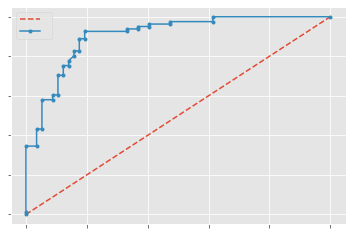

In [130]:
## Final ROC curve
# generate a no skill prediction (majority class)
y_test_coded = []
for i in y_test:
    if i == 'democrat':
        y_test_coded.append(1)
    else:
        y_test_coded.append(0)
    
    
ns_probs = [0 for _ in range(len(y_test))]
mnb_probs = clf.predict_proba(X_test)
# keep probabilities for being a republican only (column 1), democrat (column 0)
mnb_probs = mnb_probs[:, 0]
# calculate scores
ns_auc = roc_auc_score(y_test_coded, ns_probs)
mnb_auc = roc_auc_score(y_test_coded, mnb_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (mnb_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test_coded, ns_probs)
mnb_fpr, mnb_tpr, _ = roc_curve(y_test_coded, mnb_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(mnb_fpr, mnb_tpr, marker='.', label='Multinomial Bayes')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## January 2021 Update: Using Pipelining and Gridsearch to Choose Hyperparameters by Using AUC as scoring method

In [ ]:
## Naive Bayes Model
def run_model(X, y, max_feat = 1500, stop_words = sw):
    tfidf = TfidfVectorizer(stop_words = sw, ngram_range = (3,3), max_features = max_feat)
    X = tfidf.fit_transform(X)
    labels = tfidf.get_feature_names()
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 5)
# %
    clf = MultinomialNB()
    clf = clf.fit(X_train, y_train)
    cvs = np.mean(cross_val_score(clf, X_train, y_train))
    return clf, cvs, X_test, y_test, labels, X, tfidf
clf, cvs, X_test, y_test, labels, X, tfidf = run_model(df.text, df.party, stop_words = sw)



##### The code below is heavily adapted from [Towards Data Science](https://towardsdatascience.com/nlp-with-pipeline-gridsearch-5922266e82f4)

In [103]:
# Pipeline & Gridsearch setup
from sklearn.pipeline import Pipeline
X_train, X_test, y_train, y_test = train_test_split(df.text, df.party, stratify = df.party, random_state = 5)
# TFIDF pipeline setup
tvc_pipe = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('mb', MultinomialNB())
])

In [82]:
tvc_pipe.fit(X_train, y_train)

Pipeline(steps=[('tvec', TfidfVectorizer()), ('mb', MultinomialNB())])

In [116]:
tf_params = {
    'tvec__max_features':[800, 1000, 1200, 1500, 1600, 1800, 2000, 2200],
    'tvec__ngram_range': [(3, 3), (3, 4)],
    'tvec__stop_words': [sw],
    }
tf_params_2 = {
    'tvec__max_features':[2100, 2200, 2400, 2600, 3000, 4000],
    'tvec__ngram_range': [(3, 3), (3, 4)],
    'tvec__stop_words': [sw],
    }

In [117]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
kf = KFold(shuffle = True)
# Setting up GridSearch for TFIDFVectorizer
tvc_gs = GridSearchCV(tvc_pipe, param_grid=tf_params, scoring = 'roc_auc', cv = kf, verbose =1, n_jobs = None)
# Fitting TVC GS

In [94]:
type(y_train)

pandas.core.series.Series

In [118]:
tvc_gs.fit(np.array(X_train), np.array(y_train))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  2.6min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('mb', MultinomialNB())]),
             param_grid={'tvec__max_features': [800, 1000, 1200, 1500, 1600,
                                                1800, 2000, 2200],
                         'tvec__ngram_range': [(3, 3), (3, 4)],
                         'tvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'h

In [99]:
# Scoring Training data on TFIDFVectorizer
print(tvc_gs.score(X_train, y_train))
# Scoring Test data on TFIDFVectorizer
print(tvc_gs.score(X_test, y_test))

0.9986087381010496
0.8943036603855318


In [101]:
tvc_gs.best_params_

{'tvec__max_features': 2200,
 'tvec__ngram_range': (3, 3),
 'tvec__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',
  'to',
  'from',
  'up',
  'down',
  'in

In [106]:
tvc_gs_2 = GridSearchCV(tvc_pipe, param_grid=tf_params_2, scoring = 'roc_auc', cv = kf, verbose =1, n_jobs = None)
tvc_gs.fit(np.array(X_train), np.array(y_train))


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  2.5min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('mb', MultinomialNB())]),
             param_grid={'tvec__max_features': [800, 1000, 1200, 1400, 1600,
                                                1800, 2000, 2200],
                         'tvec__ngram_range': [(3, 3), (3, 4)],
                         'tvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'h

In [107]:
# Scoring Training data on TFIDFVectorizer
print(tvc_gs.score(X_train, y_train))
# Scoring Test data on TFIDFVectorizer
print(tvc_gs.score(X_test, y_test))

0.9986087381010496
0.8943036603855318


In [131]:
tvc_gs.best_params_

{'tvec__max_features': 2000,
 'tvec__ngram_range': (3, 3),
 'tvec__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',
  'to',
  'from',
  'up',
  'down',
  'in

# If a model fails in a random forest, does it even make a sound?

This model was not great, even with a gridsearch!

RandomizedSearch:

Code for search is from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [ ]:
## using randomized search to find best hyperparameters(used above)
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 220, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

My sad, sad model:

In [135]:
### fitted with grid search results
from sklearn.ensemble import RandomForestClassifier
overall_acc = []
tfidf = TfidfVectorizer(stop_words = sw, ngram_range = (1,3), max_features = 1500)
X = tfidf.fit_transform(df.text)
labels = tfidf.get_feature_names()
X_train, X_test, y_train, y_test = train_test_split(X, df.party, stratify = df.party, random_state = 5)
rf = RandomForestClassifier(n_estimators = 600, min_samples_split = 5, min_samples_leaf = 1, max_features = 'sqrt',
                           max_depth = 115, bootstrap = False)
rf = rf.fit(X_train, y_train)
acc = mean(cross_val_score(rf, X_train, y_train))

pred = rf.predict(X_test)
dem_prob_rf = rf.predict_proba(X_test)


The best threshold is [0.54]


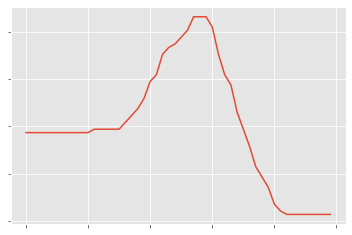

In [136]:
## Finding the best threshold for random forest
y_test_array = y_test.to_numpy()
dem_prob = rf.predict_proba(X_test)[:,0]
thresh = np.arange(0,1, .02)
thresh_acc =[]

for t in thresh:
    correct = []
    for i,v in enumerate(dem_prob):
        if v >= t and y_test_array[i] =='democrat':
            correct.append(1)
        elif v<t and y_test_array[i] == 'republican':
            correct.append(1)
        else:
            correct.append(0)

    thresh_acc.append(mean(correct))

fig, ax = plt.subplots()
ax.plot(thresh, thresh_acc)
print(f'The best threshold is {thresh[np.argsort(thresh_acc)[-1:]]}')

Accuracy was close to that of the MNB model but not better!

In [137]:
## Accuracy using .54 threshold
y_test_array = y_test.to_numpy()
correct = []
t = .56
for i,v in enumerate(dem_prob_rf[:, 0]):
    if v >= t and y_test_array[i] =='democrat':
        correct.append(1)
    elif v<t and y_test_array[i] == 'republican':
        correct.append(1)
    else:
        correct.append(0)
print(f'Accuracy: {mean(correct)}')

Accuracy: 0.8333333333333334


Really informative features!

In [138]:
important = rf.feature_importances_
idx = np.argsort(important)[-20:]

np.array(labels)[idx]

array(['reductions', 'still', 'afghanistan', 'government', 'terrorists',
       'north', 'inflation', 'give', 'south', 'soviet', 'terrorist',
       'reduction', 'race', 'stop', 'taxes', 'college', 'federal',
       'spending', 'common', 'federal government'], dtype='<U23')

January 2021 update: I would go back and chose a model based on the AUC score.

# Results & Analysis

In this section I examine:
1. The top Democratic and Republican trigrams
1. The most Republican and most Democratic speeches in the test set by log probabilities
2. The breakdown of the incorrectly/correctly identified speeches in the test set

In [ ]:
zero, one, zero_unique, one_unique = get_top_features(clf.feature_log_prob_, labels, 50)

print(f'Top Democratic Trigrams: {zero_unique}')
print(" ")
print(f'Top Republican Trigrams: {one_unique}')

In [ ]:
prob_dem_list = []
sorted_idx = np.argsort(clf.predict_proba(X_test)[:, 0])
                        
for i,v in enumerate(list(clf.predict_proba(X_test))):
    prob = v[0]
    idx = list(y_test.index)[i]
    prob_dem_list.append([prob, idx])

The top ten most Republican speeches

In [ ]:
df.iloc[np.array(prob_dem_list)[sorted_idx][:10,1]]

Top ten most Democratic speeches

In [ ]:
df.iloc[np.array(prob_dem_list)[sorted_idx][-10:,1]]

Looking at correct / Incorrect data

In [ ]:
df['accurate'] = 'na'
pred = []
idx = list(y_test.index)
for i, v in enumerate(list(y_test)):
    if v == clf.predict(X_test)[i]:
        df.loc[idx[i], 'accurate'] = True
    else:
        df.loc[idx[i], 'accurate'] = False

In [ ]:
## Updates DF with whether the speech was accurately tagged

In [ ]:
incorrect = df[df['accurate']==False]
incorrect.party.value_counts()

In [ ]:
incorrect.debate.value_counts()

In [ ]:
correct = df[df['accurate']==True]

In [ ]:
correct.debate.value_counts()

In [ ]:
df.debate.value_counts()

In [ ]:
incorrect.loc[:,['name', 'title']]

## Insights

In this section I:

1. look at log probabilities to find the most "democratic" and "republican" speeches
2. Examine the speeches that were incorrectly classified

In [ ]:
def get_most_partisan(clf, X_test, y_test):
    prob_dem_list = []
    sorted_idx = np.argsort(clf.predict_proba(X_test)[:, 0])
                        
    for i,v in enumerate(list(clf.predict_proba(X_test))):
        prob = v[0]
        idx = list(y_test.index)[i]
        prob_dem_list.append([prob, idx])
    most_rep_idx = np.array(prob_repub_list)[sorted_idx][:5,1]
    most_dem_idx = np.array(prob_dem_list)[sorted_idx][-5:,1]
    return most_rep_idx, most_dem_idx

most_rep, most_dem = get_most_partisan(clf, X_test, y_test)
print('Most Republican')
print(df.loc[most_rep, ['name', 'title']])
print('Most Democrat')
print(df.loc[most_dem, ['name', 'title']])

LBJ appears in 4 of the top 5 spots.

Republicans: Reagan, GWBush (x2), Hoover, Bush Senior.

In [ ]:
zero, one, zero_unique, one_unique = get_top_features(clf.feature_log_prob_, labels, 100)

print(f'zero: {zero}')
print(f'one: {one}')
print(f'zero unique: {zero_unique}')
print(f'one unique: {one_unique}')

In [ ]:
sw = stopwords.words('english')

new_sw = ['also', 'day','two', 'even', 'dont',"'ll", 'say', 'want', 'time', 'come', 'make', 'thing', 'le', "'m", 'go', 'thats', 'could', 'like', 'made', 'applause', 'mr', 'men', 'candidate', 'instead', 'q', 'part', "'re", "'le", 'get', 'man', "'ve", 'let', 'every', 'may', 'upon', 'shall', 'going','ve','year', '--', '``', "'s", "''", 'way', 'would',"n't", 'must','u','many','one','first','last',"'re'", 'today','', 'ha', 'wa']
for i in new_sw:
    sw.append(i)


In [ ]:
### Build confusion matrix:

In [ ]:
print(clf.predict(X_test))
print(y_test)

## Looking at correct/incorrect data

In [ ]:
df['accurate'] = 'na'
pred = []
idx = list(y_test.index)
for i, v in enumerate(list(y_test)):
    if v == clf.predict(X_test)[i]:
        df.loc[idx[i], 'accurate'] = True
    else:
        df.loc[idx[i], 'accurate'] = False

In [ ]:
## Updates DF with whether the speech was accurately tagged

In [ ]:
incorrect = df[df['accurate']==False]
incorrect.party.value_counts()

In [ ]:
incorrect.debate.value_counts()

In [ ]:
correct.debate.value_counts()

In [ ]:
correct.party.value_counts()

In [ ]:
df.debate.value_counts()

In [ ]:
correct = df[df['accurate']==True]

In [ ]:
counts_wrong = incorrect['name'].value_counts()

In [ ]:
counts_right = correct['name'].value_counts()

In [ ]:
right_wrong = pd.concat([counts_wrong, counts_right], axis = 1)
right_wrong = right_wrong.fillna(0)
right_wrong['correct %'] = (1 - right_wrong.iloc[:, 0]/(right_wrong.iloc[:, 0] + right_wrong.iloc[:, 1]))*100


Below is the percent correct for each speaker

In [ ]:
right_wrong

Below are the incorrectly identified speeches

In [ ]:
incorrect

## Analyizing Trump's speeches

In [ ]:
## loading Trump's 2016 campaign speeches
with open('corpus/trump_speech/trump.txt', 'r') as file:
    data = file.read().replace('\n', '')
trump_speeches = data.split("SPEECH")

In [ ]:
### loading Trump's 2020 Republican National Convention Speech

politico = 'https://www.politico.com/story/2016/07/full-transcript-donald-trump-nomination-acceptance-speech-at-rnc-225974'

req = requests.get(politico)
soup_link = BeautifulSoup(req.content, 'html.parser')
text = soup_link.get_text()
text = text.lower()

speech= text.split("politico thursday afternoon")

trump_speeches.append(speech[2].split("follow @ politico")[0])

In [ ]:
trump_series = pd.Series(trump_speeches)

In [ ]:
trump_vector = tfidf.fit_transform(trump_series)

print(clf.predict_proba(trump_vector)[:,0])

In [70]:
roc_curve?

Using a .54 threshold, Trump's speeches are classified as Republican only 6 out of 13 times.